In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

plt.style.use("seaborn-v0_8")

- Attribute/feature/dimension/variable of data is a dataset column (p/m/d)
- *Observations* are the observed values of a given attribute (n/N)

|          | **Numeric** | **Nominal/Categorical** | **Ordinal** | 
|----------|-------------|-------------|------------|
| **Mean** |$$Mean = \frac{\sum_{i=1}^{n} x_i}{n}$$ The outliers can easily modify the mean|no sense|no sense|
| **Median**|$$Median= \frac{n + 1}{2}$$|no sense|middle value in the ordered sequence (if number of values is even, is the average of the two middlemost values)|
| **Mode**  |most occurring value. <br>There can be multiple modes, or none if each value occurs once| == | == |
| **Quantiles** | Points taken at regular intervals of a data distribution.<br> - the 4-quantiles are three data points that split the distribution into four equal parts (*quartiles*) <br>- the 100-quantiles divide into 100 set (*percentiles*)| == | == |
| **Variance and Standard deviation** (square root of Variance)| Measures data dispersion: if it's low, the data are close to the mean value $\bar{y}$; if it's zero, all observations have the same value: $$ \frac{1}{n} \sum_{i=1}^{n} (y_i - \bar{y})^2 $$ | == | == |
| **Covariance** (between two variables)| It's a measure of the joint variability of two variables. The covariance is positive if the larger values of one variable mainly correspond with the larger values of the other variable, and the same holds for the lesser values (that is, the variables tend to show similar behavior). In the opposite case, when the greater values of one variable mainly correspond to the lesser values of the other, (that is, the variables tend to show opposite behavior), the covariance is negative. $$ \sigma_{x,y} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y}) $$ | == | == |

---
### Distance between numeric variables
- **Euclidean distance**
- **Manhattan distance** (or city block)
- **Cosine**
- ...

---
### Distance between ordinal variables
- Same as numeric variables, but first you have to compute a normalization to the variable 

In [3]:
df = (
    pd.read_csv("datasets/nba.csv")[["League", "Stage"]]
    .query('League in ["NBA", "Eurocup", "EuroLeague"]')
    .drop_duplicates()
)

display(df)

,League,Stage
0,NBA,Regular_Season
207,NBA,Playoffs
1340,Eurocup,International


In [4]:
# INTEGER ENCODE of one column
LabelEncoder().fit_transform(df.Stage)

array([2, 1, 0])

---
### Distance between nominal variables

- **Ratio of mismatches**
    - Is the distance between two samples, especially when the variables are nominal. 
    - It's a great alternative to OHE because it doesn't grow the number of columns.
- **One Hot Encoding**
    - from categorical to numerical data
    - assume that one variable (column) can assume k different values, the variable is replaced with k columns where each represents one possible value of the variable. The cell number of the k-th column is 1 if the original variable assumes that value, or 0 otherwise

In [5]:
from sklearn.compose import ColumnTransformer

# Apply OneHotEncoder to columns 2 and 3
# remainder=passthrough: the other columns have to keep the same
ColumnTransformer(
    [("encoder", OneHotEncoder(), [0, 1])], remainder="passthrough"
).fit_transform(df)

array([[0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 0.]])

In [6]:
# One Hot Encoding
# the values are True/False
display(pd.get_dummies(df))

,League_Eurocup,League_NBA,Stage_International,Stage_Playoffs,Stage_Regular_Season
0,False,True,False,False,True
207,False,True,False,True,False
1340,True,False,True,False,False


In [7]:
# BINARY ENCODING
# the values are 0/1
OneHotEncoder(sparse_output=False).fit_transform(df)

array([[0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 0.]])

---
---
- For *incomplete data* (lacking feature values):
    - Ignore the sample if the sample contains several attributes with missing values
    - Manually fill in the missing values (Time-consuming)
    - Use a global constant value to fill in the missing values
        - Replace all missing attribute values with the same constant (i.e. -1). The ML algorithm may (mistakenly) interpret this as a pattern(several samples with a value in common)
    - Use a measure like the mean (or median) to fill in the missing values:
        - for normal (symmetric) data distributions => mean/median (are equals)
        - for skewed data distribution => median
        - It can be used the feature mean/median for all samples belonging to the same class

- For *noisy data* (containing errors, or values that deviate from the expected):
    -  Smooth a sorted data value by looking at the values around it (neighborhood) => **Binning**
        - The sorted values are distributed in bins (buckets) with equal width. For example, integers ordered in [0,5]: [0,1] [2,3] [4,5]
        - Smoothing by bin means: each value in a bin is replaced by the mean value of the bin
        - Smoothing by bin medians: each bin value is replaced by the bin median 
        - Smoothing by bin boundaries: the minimum and maximum values in a given bin are identified as the bin boundaries. Each bin value is replaced by the closest boundary value

- For *inconsistent data* (feature duplication, sample duplication, human error in data entry, deliberate errors, inconsistent data representations, inconsistent use of codes, errors from the devices that record data, system errors): ...

---
## Unbalanced data
Given data divided in classes, it's unbalanced if one class is represented by too few (or too many) samples compared to other classes. <br>
****IMPORTANT: SPLIT DATA IN TRAIN/VAL/TEST BEFORE RESAMPLE**** <br>
- **Oversampling**: resample(duplicate) the rare samples so that the resulting training set contains classes with an equal number of samples. SMOTE: synthetic tuples are added to the dataset: Synthetic samples are “close to” the given samples in the space.
- **Undersampling**: randomly eliminate tuples, decreasing the number of samples for the class with the larger number of tuples. With the excluded samples you can repeat the training (**trials**) 10/100 times, or you can use the remaining data to form the test set.

In [8]:
# Generate a random n-class classification problem:
# weights parameter to manage the proportions of samples assigned to each class
# flip_y parameter to manage the fraction of samples whose class is assigned randomly
X, y = make_classification(n_samples=1000, weights=[0.99], flip_y=0)
print(np.unique(y, return_counts=True))

# Oversample
oversample = RandomOverSampler(sampling_strategy="minority")
X_over, y_over = oversample.fit_resample(X, y)
print(np.unique(y_over, return_counts=True))

# Undersample
undersample = RandomUnderSampler(sampling_strategy="majority")
X_under, y_under = undersample.fit_resample(X, y)
print(np.unique(y_under, return_counts=True))

(array([0, 1]), array([990,  10]))
(array([0, 1]), array([990, 990]))
(array([0, 1]), array([10, 10]))


---
## Pre-Processing Techniques
https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

### L1 and L2 Normalization
It scales the min-max range of feature values, rescaling the data in [-1,1]
- Given a sample (row), the norm is computed over all the columns and applied (divided) only to the row (each row has its norm)
- L1 normalization scales the data so that the sum of the absolute values of each feature is equal to 1. Used in Feature Selection: L1 regularization (Lasso) adds the absolute value of the coefficient as a penalty term to the loss function, encouraging sparsity in the model. *It keeps the sparsity of the data.*
- L2 normalization scales the data so that the sum of the squared values of each feature is equal to 1. Used in Linear regression: L2 regularization (Ridge) adds the squared magnitude of the coefficient as a penalty term to the loss function, preventing overfitting. *When you want to maintain the relative relationships between features and avoid extreme weights.*

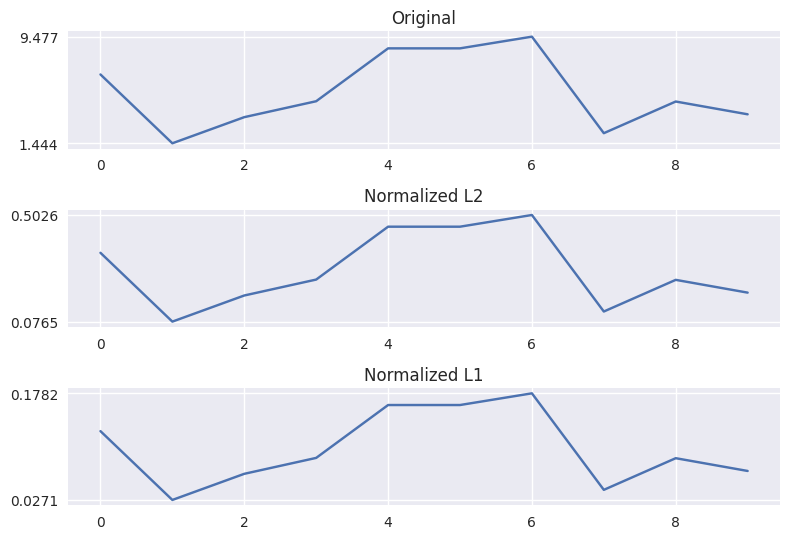

In [9]:
np.random.seed(42)
x = np.random.uniform(10, size=10)


# L2
x_norm2 = np.linalg.norm(x, ord=2)
x_normalized2 = x / x_norm2

# L1
x_norm1 = np.linalg.norm(x, ord=1)
x_normalized1 = x / x_norm1

rows, cols = (3, 1)
plt.subplot(rows, cols, 1)
plt.plot(x)
plt.yticks([x.min(), x.max()])
plt.title("Original")

plt.subplot(rows, cols, 2)
plt.plot(x_normalized2)
plt.yticks([x_normalized2.min(), x_normalized2.max()])
plt.title("Normalized L2")

plt.subplot(rows, cols, 3)
plt.plot(x_normalized1)
plt.yticks([x_normalized1.min(), x_normalized1.max()])
plt.title("Normalized L1")

plt.tight_layout()  # distance between subplots
plt.show()

### Min-Max Scaling (Min-Max normalization)
rescales feature values to the [0, 1] range.
- ****IMPORTANT: MAX AND MIN MUST BE COMPUTED ONLY ON THE TRAINING SET AND APPLIED TO THE TRAIN/VAL/TEST SETS**** because we assume the train set is representative
- Min and max are computed for each variable (along with all the samples)
- Used if the data does ***NOT follow a Gaussian distribution***. This can be useful in algorithms that do not assume any distribution of the data (like K-Nearest Neighbors and Neural Networks). When you want to handle features with different ranges or units of measurement.

### Standardization (Z-Score Normalization)
It centers the features at mean 0 with standard deviation 1
- ****IMPORTANT: MEAN AND VARIANCE MUST BE COMPUTED ONLY ON THE TRAINING SET AND APPLIED TO THE TRAIN/VAL/TEST SETS**** because we assume the train set is representative
- Mean and std are computed for each variable (along with all the samples)
- Used if the data follow a Gaussian distribution. Standardization does not have a bounding range, so the outliers will not be affected by standardization

In general, start by fitting the model from raw data, then min-max scaled, then standardized, and compare the performance.

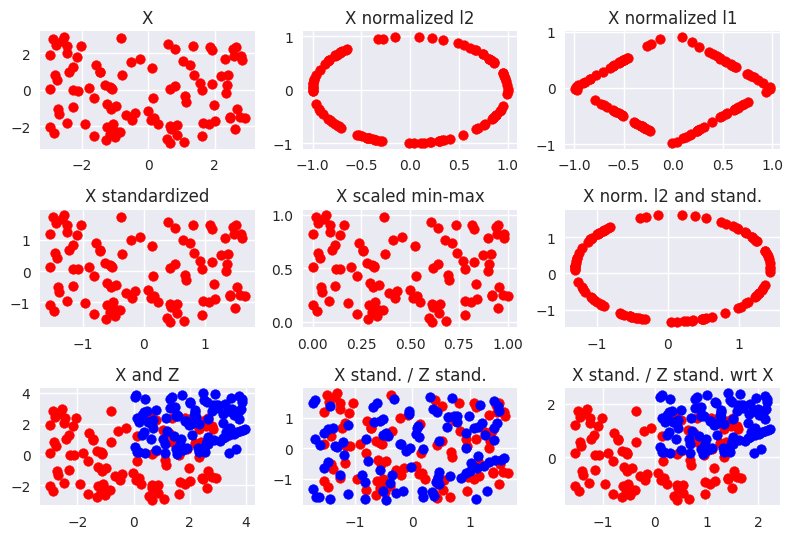

In [10]:
translate_X = 0  # -2
translate_Z = 2  # -2
magnitude_X = 3  # try 1000!
magnitude_Z = 2  #


# Our dataset is composed by 100 samples and 2 variables
X = np.random.uniform(-magnitude_X, magnitude_X, size=(100, 2)) + translate_X
X[:, 1] = X[:, 1]  # try this!


# Normalization
# X_norm2 = np.linalg.norm(X, ord=2, axis=1, keepdims=True)
# X_normalized2 = X / X_norm2
X_normalized2 = normalize(X, norm="l2")  # l1, l2, max

X_norm1 = np.linalg.norm(X, ord=1, axis=1, keepdims=True)
X_normalized1 = X / X_norm1
# X_normalized1 = preprocessing.normalize(X, norm='l1') # l1, l2, max


# Standardization, assumption: X is the training set
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std
# scaler = preprocessing.StandardScaler()
# scaler.fit(X)
# X_standardized2 = scaler.transform(X)


# Min-Max scaling, assumption: X is the training set
X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)
X_scaled = (X - X_min) / (X_max - X_min)
# scaler = preprocessing.MinMaxScaler()
# scaler.fit(X)
# X_scaled2 = scaler.transform(X)


# A bit strange...
X_normalized2_standardized = (X_normalized2 - np.mean(X_normalized2, axis=0)) / np.std(
    X_normalized2, axis=0
)


plt.subplot(331)
plt.scatter(X[:, 0], X[:, 1], c="r")
plt.title("X")

plt.subplot(332)
plt.scatter(X_normalized2[:, 0], X_normalized2[:, 1], c="r")
plt.title("X normalized l2")

plt.subplot(333)
plt.scatter(X_normalized1[:, 0], X_normalized1[:, 1], c="r")
plt.title("X normalized l1")

plt.subplot(334)
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], c="r")
plt.title("X standardized")

plt.subplot(335)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c="r")
plt.title("X scaled min-max")

plt.subplot(336)
plt.scatter(X_normalized2_standardized[:, 0], X_normalized2_standardized[:, 1], c="r")
plt.title("X norm. l2 and stand.")


# Another dataset
Z = np.random.uniform(-magnitude_Z, magnitude_Z, size=(100, 2)) + translate_Z


Z_mean = np.mean(Z, axis=0)
Z_std = np.std(Z, axis=0)

Z_standardizedZ = (Z - Z_mean) / Z_std

Z_standardizedX = (Z - X_mean) / X_std


plt.subplot(337)
plt.scatter(X[:, 0], X[:, 1], c="r")
plt.scatter(Z[:, 0], Z[:, 1], c="b")
plt.title("X and Z")

plt.subplot(338)
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], c="r")
plt.scatter(Z_standardizedZ[:, 0], Z_standardizedZ[:, 1], c="b")
plt.title("X stand. / Z stand.")

plt.subplot(339)
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], c="r")
plt.scatter(Z_standardizedX[:, 0], Z_standardizedX[:, 1], c="b")
plt.title("X stand. / Z stand. wrt X")

plt.tight_layout()
plt.show()